**Steps to preprocess EEG data generally include the following:**<br/>
*1. Importing the raw data*<br/>
*2. Bandpass filter*<br/>
*3. Re-reference data*<br/>
*4. Inspect electrodes and reject noisy channels*<br/>
*5. Epoch the data*<br/>
*6. Inspect and reject noisy epochs*<br/>
*7. Run independent component analysis and reject noisy components*<br/>
*8. Save preprocessed data*<br/>

================================== Importing the required Libraries ===========================

In [2]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn import decomposition

========================================= Functions ==================================

In [109]:
# =============================================== Preparing data =========================================================
def Prepare_data(data, channels=None):  
    # ?------------------------------------------- Check type data -------------------------------------------      
    if 'DataFrame' not in str(type(data)):      
        data = pd.DataFrame(data)
    # !--------------------------------------- Check dimensional data ----------------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
    # *--------------------------------------------- Set channels --------------------------------------------
    if channels is not None:
        data.columns=channels 
    else:
        data.columns = np.arange(1,data.shape[1]+1)
         
    return data, data.columns

# ================================================= Plot data ============================================================
def plot_data(data, first_point=0, last_point=100, channels=None, Fs=None, normalize_data='on'):
    # ?--------------------------- Check type, dimensional data & set channels -------------------------------
    if data.ndim < 3:
        if data.shape[0] < data.shape[1]:
            data = data.T
    elif data.ndim > 3:
        print("Please configure the data as two-dimensional (Sample * Channels)")
        sys.exit()
        
    if 'DataFrame' not in str(type(data)):     
        data = pd.DataFrame(data)
        
    if channels is not None:
        data.columns=channels 
    else:
        data.columns = np.arange(1,data.shape[1]+1)
    # *------------------------------------------ Normalize data ---------------------------------------------
    if normalize_data == 'on':
        data = (data-np.min(data.values, axis=0))/(np.max(data.values, axis=0)-np.min(data.values, axis=0))
    # !-------------------------------------------- Set figure -----------------------------------------------   
    _, axs = plt.subplots(nrows=1,sharey='row', figsize=(7,5))

    data = data.iloc[first_point:last_point,:]
    if Fs is not None and np.array(Fs) > 0:
        time = (np.linspace(start=first_point/Fs, stop=last_point/Fs, num=len(data))).flatten()
        axs.plot(time, data + 80*np.arange(data.shape[1],0,-1))
        axs.set_xlabel('Time (sec)', fontsize=10)
    else:
        axs.plot(data + 80*np.arange(data.shape[1],0,-1))
        axs.set_xlabel('sample', fontsize=10)
    axs.set_ylim([np.min(80*np.arange(data.shape[1],0,-1))+np.min(data.iloc[:,data.shape[1]-1]), np.max(80*np.arange(data.shape[1],0,-1))+np.max(data.iloc[:,0])])
    axs.set_yticks((80*np.arange(data.shape[1],0,-1)))
    axs.set_yticklabels(data.columns)
    axs.tick_params(axis='x', labelsize=8)
    axs.tick_params(axis='y', labelsize=8)
    axs.set_ylabel('Channels', fontsize=10)
    axs.autoscale(enable=None, axis="y", tight=True)
    axs.tick_params(axis='y', color='k', labelcolor='k')
# ============================================== Channel locations =======================================================
def channel_locations(Th, Rd, channels):
    # ?------------------------------------------- Check type data -------------------------------------------  
    if 'Series' not in str(type(Th)):      # Check type Th
        Th = pd.Series(Th)
    if 'Series' not in str(type(Rd)):      # Check type Rd
        Rd = pd.Series(Rd)
    # *-------------------------------------- Convert degree to radian ---------------------------------------  
    if Th.max() > 20:
        Th = (np.pi/180)*Th
    elif Rd.max() > 20:
        Rd = (np.pi/180)*Rd
    sq = 0.5/max(min(1.0,max(Rd)*1.02),0.5)
    #Rd = Rd * sq
    # ---------------------------------------------- Circle --------------------------------------------------  
    x = Rd * np.cos(Th) * sq
    y = Rd * np.sin(Th) * sq
    circ = np.linspace(start=0,stop=2*np.pi,num=200).flatten()
    rx = np.sin(circ).tolist()
    ry = np.cos(circ).tolist()
    hx = np.dot(rx,1.06)
    hy = np.dot(ry,1.06)   
    # ---------------------------------------------- right & left ear ----------------------------------------
    EarX  = np.dot([.497-.005, .510, .518, .5299, .5419, .54, .547, .532, .510, .489-.005], 1.13); 
    EarY  = np.dot([0.04+.0555, 0.04+.0775, 0.04+.0783, 0.04+.0746, 0.02+.0555, -.0055, -.0932, -.1313, -.1384, -.1199], 1.13)
    # !-------------------------------------------- Set figure -----------------------------------------------       
    fig, axs = plt.subplots(nrows=1, sharey='row', figsize=(2.7,2.7), facecolor='#D6D6D6')

    """hin = 1.06                 # hin = sq*plotrad*(1- 0.007/2)   # inner head ring radius
    hx = np.dot(rx,hin)
    hy = np.dot(ry,hin)
    axs.plot(np.dot([0.09, 0.02, 0, -0.02, -0.09],sq), np.dot([0.4954, 0.57, 0.575, 0.57, 0.4954], sq), 'k') # plot nosث
    """
    axs.plot(np.dot(hx, max(y)), np.dot(hy,max(y)), 'k')
    axs.plot(np.dot(EarX,sq), np.dot(EarY,sq), 'k')    # plot right ear
    axs.plot(-np.dot(EarX,sq), np.dot(EarY,sq), 'k')   # plot left ear
    axs.plot(np.dot([0.08, 0.01, 0, -0.01, -0.08],0.775), np.dot([0.4954, 0.57, 0.575, 0.57, 0.4954], 0.775), 'k') # plot nose

    axs.plot(y, x, '.')
    for i in range(0, len(channels)):
        axs.text(y[i], x[i]+0.0255, channels[i], fontsize=5.5, horizontalalignment='center', verticalalignment='center')
   
    axs.set_axis_off()
    axs.set_title('Channel locations',  fontsize=8.5)
    axs.set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    #axs.autoscale(enable=None, axis="y", tight=True)

In [105]:
np.min(data.iloc[:,data.shape[1]-1])

-71.7639999389648

*1. Importing the raw data*

In [63]:
df=pd.read_excel("EEG_Data.xlsx",sheet_name=None)
print(f"List of sheets: {df.keys()}")

List of sheets: dict_keys(['data', 'time', 'channels', 'event', 'urevent', 'Fs'])


In [94]:
np.max(80*np.arange(data.shape[1],0,-1))

2560

In [64]:
data=df['data']
time=df['time']                         # Time (msec)
Fs=df['Fs']                             # Sampling rate (Hz)
channels=df['channels']['labels']       # Name of channel
Th=df['channels']['Th']                 # Theta for plot channels
Rd=df['channels']['Rd']                 # Radius for plot channels

*1.1. Preparing data*

In [65]:
data, channels = Prepare_data(data, channels)

*1.2. Plot data & channel locations*

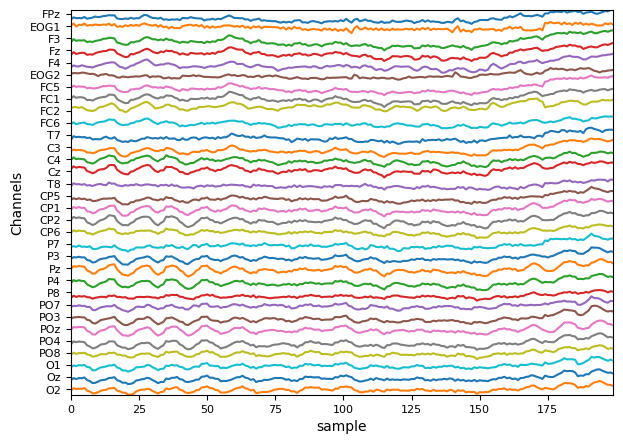

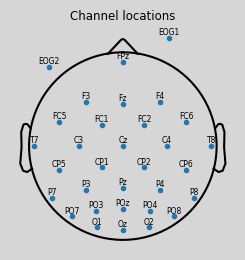

In [112]:
first_point = 0
last_point = 200
plot_data(data, first_point, last_point,channels, Fs=None, normalize_data='off')
channel_locations(Th, Rd, channels)

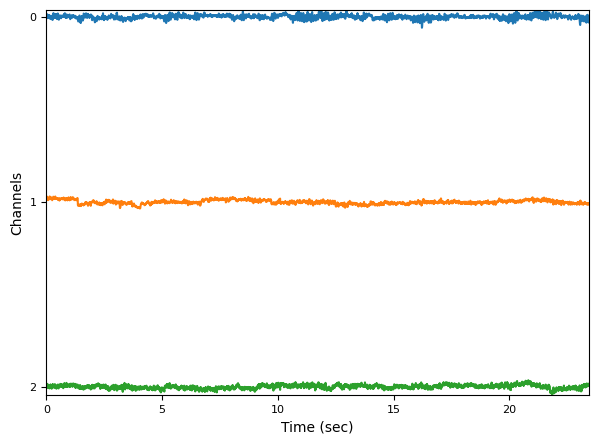

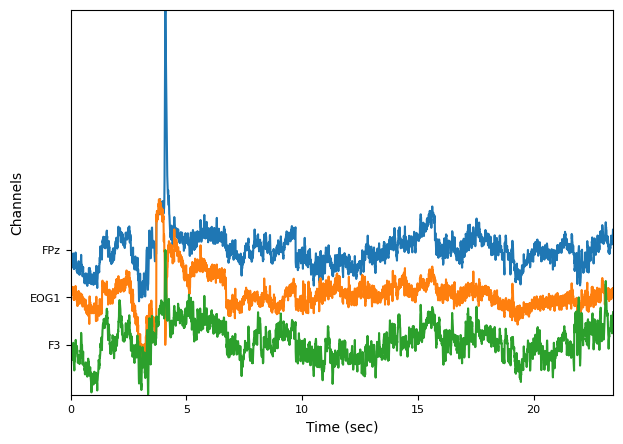

In [126]:
transformer = decomposition.FastICA(n_components=32, whiten='unit-variance', random_state=42)
X_transformed = transformer.fit_transform(data)
X_transformed.shape
plot_data(X_transformed[:,0:3],first_point, last_point, Fs)
plot_data(data.iloc[:,0:3],first_point, last_point, Fs)


In [41]:
def ICA(data):                         # Independent Component Analysis (ICA) Algorithm
    
            

In [97]:
data_centered = data - np.mean(data, axis=0)                   # Center x by subtracting the mean (Remove overall row means of data)
cov_matrix = np.cov(data_centered.T)                           # compute the covariance matrix
U, eigenvalues, eigenvectors = np.linalg.svd(cov_matrix)       # Single value decoposition
diag = np.diag(1.0 / np.sqrt(eigenvalues))                     # Calculate diagonal matrix of eigenvalues
whitening = np.dot(U, np.dot(diag, U.T))                       # Calculate whitening matrix (correlations between the signals are removed and their variances equal unity.)
data_whitening = data_centered.dot(whitening)                  # Project onto whitening matrix
weight = np.random.rand(data.shape[1], data.shape[1])          # Initialize random weights

alpha = 1
threshold=1e-8
epochs=20
for i in range(data_whitening.shape[1]):
    w = weight[i, :].copy().reshape(data_whitening.shape[1], 1)
    w = w / np.sqrt((w ** 2).sum())
    
    j = 0
    lim = 100
    while ((lim > threshold) & (j < epochs)):
        
        ws = np.dot(w.T, data_whitening.T)                         # Dot product of weight and signal
        wg = np.tanh(ws * alpha).T                                 # Pass w*s into contrast function g
        wg_ = (1 - np.square(np.tanh(ws))) * alpha                 # Pass w*s into g prime
        weight_new = (data_whitening * wg).mean(axis=0) - wg_.mean() * w.squeeze() # Update weights
        weight_new = weight_new - np.dot(np.dot(weight_new, weight[:j].T), weight[:j])  # Decorrelate weights 
        weight_new = weight_new / np.sqrt((weight_new ** 2).sum())
        lim = np.abs(np.abs((weight_new * w.flatten()).sum()) - 1)     # Calculate limit condition
        weight[i, :] = weight_new  # Update weights
        j += 1   # Update counter 
    

[[0.18413592 0.85771445 0.69075159 ... 0.9600274  0.20068458 0.2657988 ]
 [0.91405739 0.80328647 0.37449263 ... 0.79184479 0.70304751 0.94326769]
 [0.55228378 0.09417015 0.99992225 ... 0.03927231 0.61085474 0.04845372]
 ...
 [0.22316916 0.78613033 0.43614195 ... 0.83028776 0.00530852 0.02151378]
 [0.79889598 0.50016088 0.98459407 ... 0.53103182 0.30503792 0.61768906]
 [0.93476046 0.63810127 0.7415425  ... 0.3288647  0.25114102 0.83793272]]


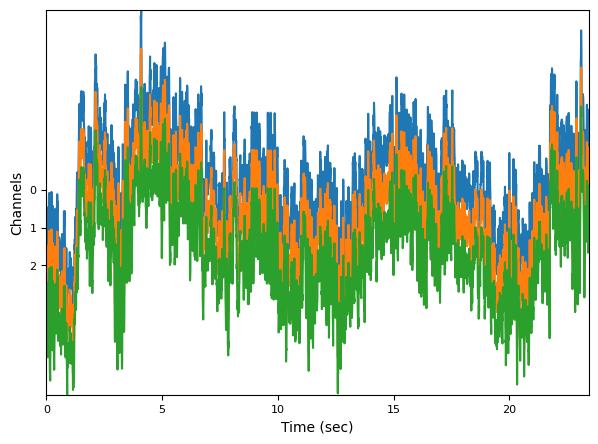

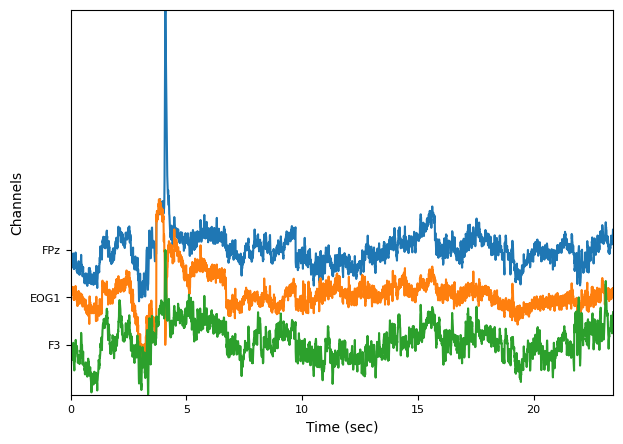

In [125]:
u = data_centered.dot(weight.T)

plot_data(u.iloc[:,0:3],first_point, last_point, Fs)
plot_data(data.iloc[:,0:3],first_point, last_point, Fs)

In [ ]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean
    return centered, mean


def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

# Center signals
Xc, meanX = center(X)

# Whiten mixed signals
Xw, whiteM = whiten(Xc)

In [19]:
chans = data.shape[1]
ncomps = chans
Mean = np.mean(data,axis=0)
data_new = data-Mean
sphere=0.2*linalg.inv(linalg.sqrtm(np.cov(data_new.T)))
weights = np.eye(ncomps,chans);  # begin with the identity matrix
data = np.dot(sphere, data_new.T); # decorrelate the electrode signals by 'sphereing' them

In [71]:
# Initialize ICA training
DEFAULT_BLOCK = np.ceil(min(5*np.log(30504),0.3*30504)); # heuristic 
block = DEFAULT_BLOCK
lastt=np.fix((30504/block-1)*block+1)
BI=block*np.eye(ncomps,ncomps)
delta=np.zeros((1,chans*ncomps))

changes = []
degconst = 180/np.pi
startweights = weights
prevweights = startweights
oldweights = startweights
prevwtchange = np.zeros((chans,ncomps))
oldwtchange = np.zeros((chans,ncomps))
DEFAULT_MAXSTEPS  = 512;       # top training after this many steps 
maxsteps = DEFAULT_MAXSTEPS
DEFAULT_NSUB   = 1;        # initial default number of assumed sub-Gaussians
lrates = np.zeros((1,maxsteps))
onesrow = np.ones((1,round(block)))
bias = np.zeros((ncomps,1))
signs = np.ones(ncomps)    #  initialize signs to nsub -1, rest +1

"""
signs = np.diag(signs); # make a diagonal matrix
oldsigns = np.zeros(np.size(signs))
signcount = 0;              #counter for same-signs
signcounts = []
urextblocks = 1;   # original value, for resets
old_kk = np.zeros((1,ncomps));  # for kurtosis momemtum"""

'\nsigns = np.diag(signs); # make a diagonal matrix\noldsigns = np.zeros(np.size(signs))\nsigncount = 0;              #counter for same-signs\nsigncounts = []\nurextblocks = 1;   # original value, for resets\nold_kk = np.zeros((1,ncomps));  # for kurtosis momemtum'

*2. Import events and channel locations*

*3. Re-reference and down-sample data*

*4.1. Remove Baseline (Remove mean of each data channel)*<br/>
*4.2. Filter Data*

In [ ]:
def Plot_EEG(data, channel,Fs):
    fig, axs = plt.subplots(nrows=1, figsize=(7,5))
    axs.set_yticks((80*np.arange(data.shape[0], -1,-1)))
    
fig, axs = plt.subplots(nrows=1, figsize=(7,5))
axs.set_yticks((100*np.arange(31, -1,-1)))
axs.set_yticklabels(reversed(channel))
data=data.iloc[::-1]
axs.plot(data.iloc[:,200:1000].T + 100*np.arange(31,-1,-1))

In [207]:
def center(x):
    mean = np.mean(x, axis=0)
    centered =  x - mean
    return centered, mean
def covariance(x):
    mean = np.mean(x, axis=0)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n
def whiten(x):
    x=x.T
    # Calculate the covariance matrix
    coVarM = covariance(x)
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S))
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    # Project onto whitening matrix
    Xw = np.dot(whiteM, x)
    return Xw, whiteM
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=20):
    m, n = signals.shape

    # Initialize random weights
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Dot product of weight and signal
                ws = np.dot(w.T, signals)

                # Pass w*s into contrast function g
                wg = np.tanh(ws * alpha).T

                # Pass w*s into g prime
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Update weights
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Decorrelate weights              
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Calculate limit condition
                lim = np.abs(np.abs((wNew * w).sum()) - 1)

                # Update weights
                w = wNew

                # Update counter
                i += 1

            W[c, :] = w.T
    return W

In [211]:
X=data
Xc, meanX = center(X)
Xw, whiteM = whiten(Xc)

In [ ]:
print(np.round(covariance(Xw)))
W = fastIca(Xw,  alpha=1)
print(W)

**Independent Component Analysis:**<br/>
ICA is a powerful technique for separating independent sources from a mixed signal, it assumes that the sources are *non-Gaussian* and *independent* from each other. If the sources are *Gaussian* or *dependent* it may be needed to use different techniques like *Principal Component Analysis (PCA)* or *Non-negative Matrix Factorization (NMF)*.<br/>
https://www.mriquestions.com/uploads/3/4/5/7/34572113/ica_math.pdf<br/>

***Definition of ICA:***<br/>
*$x_{j}=a_{j1}s_{1}+a_{j2}s_{2}+...+a_{jn}s_{n} \rightarrow X(t)= As(t)\rightarrow w=A^{-1}$*

 - A is an unknown matrix (mixing matrix) 
 - x(t) is observed signals 
 - s(t) is source signals
 - objective is to recover the original signals (s) from the observed vector x(t) *$\rightarrow s(t)= wx(t)$*<br/>
 
*ICA encompasses these steps:*
1. Center x by subtracting the mean *$\rightarrow x_{c} = x-mean(x)$* & covariance ($x_{c} $) 
2. Compute the eigenvalues and eigenvectors in order to aligning the first principal component with the eigenvector of the highest eigenvalue
2. Whiten x $\rightarrow$ Whitening involves linearly transforming the observation vector such that its components are uncorrelated and have unit variance ($cov(x_{w}x_{w}^{T})=I$)
3. Choose a random initial value for the de-mixing matrix w
4. Calculate the new value for w
5. Normalize w
6. Check whether algorithm has converged and if it hasn’t, return to step 4
7. Take the dot product of w and x to get the independent source signals



Kurtosis is the classical method of measuring NonGaussianity. When data is preprocessed to have unit variance, kurtosis is equal to the fourth moment of the data.




In [32]:
data_centered = data- np.mean(data, axis=0)                          # Center the data
data_cov = np.cov(data_centered.T)                                   # Compute the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(data_cov)                  # Compute the eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]                                    # Arrange eigenvalues and eigenvectors in descending order, aligning the first principal component with the eigenvector of the highest eigenvalue
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)   # Normalize the eigenvectors to have unit length
data_whitened = data_centered.dot(eigenvectors)                      # whiten the data
A = np.linalg.pinv(eigenvectors).dot(data_whitened.T)                # estimate the mixing matrix (pseudo-inverse of the eigenvectors matrix.)
S = data_whitened.T.dot(A.T)                                         # estimate the independent sources

In [45]:
A.shape

(32, 30504)

In [38]:
np.cov(data_whitened.T,data_whitened.T)

array([[ 9.71146145e+03,  1.54330544e-13,  4.66569619e-13, ...,
        -2.21411853e-12, -3.65968527e-13,  4.06906671e-13],
       [ 1.54330544e-13,  3.03978470e+03, -1.13237353e-12, ...,
        -5.59660664e-13, -3.85938172e-14,  1.78344992e-13],
       [ 4.66569619e-13, -1.13237353e-12,  1.24445374e+03, ...,
         2.09088667e-14, -9.21406420e-14, -5.47133980e-15],
       ...,
       [-2.21411853e-12, -5.59660664e-13,  2.09088667e-14, ...,
         7.65646579e+00, -1.67806350e-13,  2.78489984e-13],
       [-3.65968527e-13, -3.85938172e-14, -9.21406420e-14, ...,
        -1.67806350e-13,  6.92034658e+00,  2.01883773e-13],
       [ 4.06906671e-13,  1.78344992e-13, -5.47133980e-15, ...,
         2.78489984e-13,  2.01883773e-13,  4.88006049e+00]])

In [31]:
S

array([[ 6.40918904e+07, -1.28810902e+08,  1.54133376e+07, ...,
        -2.78190721e+06, -6.55671360e+06,  3.38154485e+06],
       [ 5.02710979e+06, -9.59196394e+06,  4.60668894e+07, ...,
         8.42455238e+05, -1.01712068e+06, -4.51132053e+04],
       [ 8.61863741e+06, -9.62393159e+06,  1.29675241e+06, ...,
         6.64933196e+06, -3.31599607e+05, -4.44312811e+06],
       ...,
       [ 3.13008623e+04,  4.37592687e+04,  3.45081210e+04, ...,
        -1.21573035e+04,  1.10751842e+05, -9.52715577e+04],
       [ 2.67615917e+04,  4.00981822e+04,  2.10976910e+04, ...,
         6.73471487e+04,  9.10761953e+03,  1.42524122e+05],
       [ 1.82011668e+04,  3.01137050e+04,  5.80729265e+03, ...,
        -1.45399051e+04, -7.97663514e+04, -5.23332701e+04]])

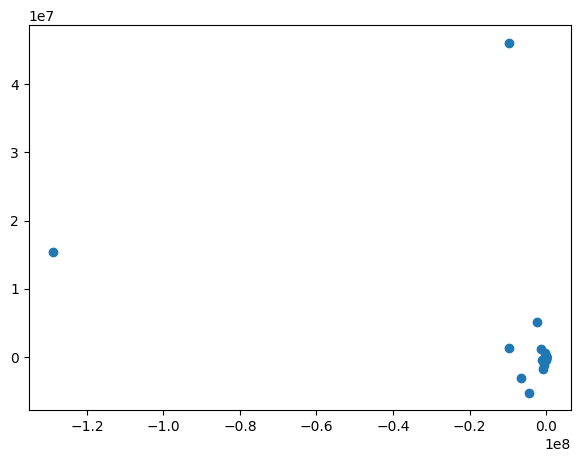

In [26]:
fig, axs = plt.subplots(nrows=1, figsize=(7,5))
axs.scatter(S[:, 1], S[:, 2])

In [23]:
S.shape

(32, 32)